In [1]:
pwd

'C:\\Users\\Prathmesh\\Desktop\\EDI\\GitHubRepo\\Shirt_MRCNN\\samples'

In [2]:
cd EDI

C:\Users\Prathmesh\Desktop\EDI\GitHubRepo\Shirt_MRCNN\samples\EDI


# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [21]:


from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
import tensorflow as tf
import time
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.models import load_model
%matplotlib inline
from os import listdir
from xml.etree import ElementTree


import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/EDI/"))  # To find local version
import shirt

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "logs/shirt20200927T0848/mask_rcnn_shirt_0030.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

In [4]:
class myMaskRCNNConfig(Config):
    # give the configuration a recognizable name
    NAME = "MaskRCNN_config"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # number of classes (we would normally add +1 for the background)
     # kangaroo + BG
    NUM_CLASSES = 1+1
   
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 131
    
    # Learning rate
    LEARNING_RATE=0.006
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    # setting Max ground truth instances
    MAX_GT_INSTANCES=10

In [5]:
config = myMaskRCNNConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.006
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [6]:
class InferenceConfig(shirt.CustomConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [7]:
class InferenceConfig(shirt.CustomConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [8]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Re-starting from epoch 30


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [9]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['fs', 'hs']

In [23]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

## Run Object Detection

Processing 1 images
image                    shape: (350, 350, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


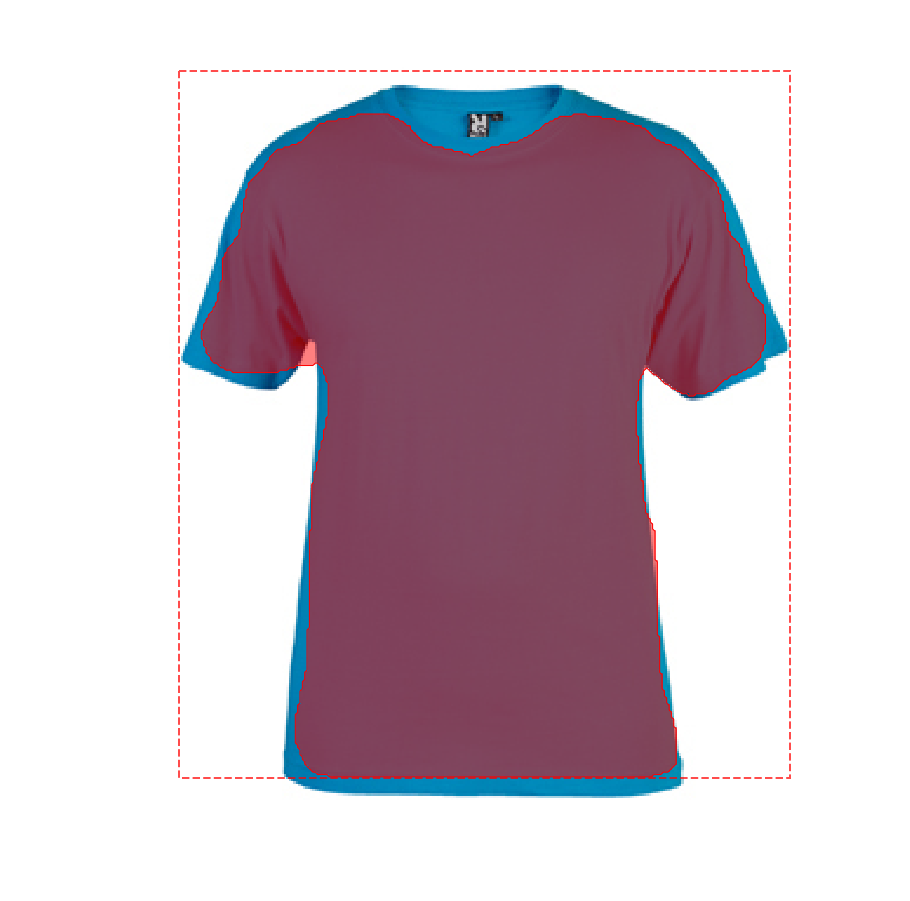

In [14]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [18]:
import shirt 
dataset = shirt.CustomDataset()
SHIRT_DIR=r'C:\Users\Prathmesh\Desktop\EDI\GitHubRepo\Shirt_MRCNN\samples\EDI\dataset/'
dataset.load_custom(SHIRT_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

{'filename': 'HS0.jpg', 'size': 15239, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [113, 96, 300, 288, 338, 330, 287, 254, 240, 186, 146, 91, 59], 'all_points_y': [312, 512, 511, 297, 291, 221, 182, 162, 186, 196, 161, 192, 289]}, 'region_attributes': {}}], 'file_attributes': {}}
C:\Users\Prathmesh\Desktop\EDI\GitHubRepo\Shirt_MRCNN\samples\EDI\dataset/val/HS0.jpg
C:\Users\Prathmesh\Desktop\EDI\GitHubRepo\Shirt_MRCNN\samples\EDI\dataset/val/HS0.jpg
C:\Users\Prathmesh\Desktop\EDI\GitHubRepo\Shirt_MRCNN\samples\EDI\dataset/val/HS1.jpg
C:\Users\Prathmesh\Desktop\EDI\GitHubRepo\Shirt_MRCNN\samples\EDI\dataset/val/HS1.jpg
C:\Users\Prathmesh\Desktop\EDI\GitHubRepo\Shirt_MRCNN\samples\EDI\dataset/val/HS2.jpg
C:\Users\Prathmesh\Desktop\EDI\GitHubRepo\Shirt_MRCNN\samples\EDI\dataset/val/HS2.jpg
C:\Users\Prathmesh\Desktop\EDI\GitHubRepo\Shirt_MRCNN\samples\EDI\dataset/val/HS3.jpg
C:\Users\Prathmesh\Desktop\EDI\GitHubRepo\Shirt_MRCNN\samples\EDI\dataset/val/HS3.jpg
C:\Use

C:\Users\Prathmesh\Desktop\EDI\GitHubRepo\Shirt_MRCNN\samples\EDI\dataset/val/FS7.jpg
C:\Users\Prathmesh\Desktop\EDI\GitHubRepo\Shirt_MRCNN\samples\EDI\dataset/val/FS7.jpg
C:\Users\Prathmesh\Desktop\EDI\GitHubRepo\Shirt_MRCNN\samples\EDI\dataset/val/FS8.jpg
C:\Users\Prathmesh\Desktop\EDI\GitHubRepo\Shirt_MRCNN\samples\EDI\dataset/val/FS8.jpg
C:\Users\Prathmesh\Desktop\EDI\GitHubRepo\Shirt_MRCNN\samples\EDI\dataset/val/FS9.jpg
C:\Users\Prathmesh\Desktop\EDI\GitHubRepo\Shirt_MRCNN\samples\EDI\dataset/val/FS9.jpg
C:\Users\Prathmesh\Desktop\EDI\GitHubRepo\Shirt_MRCNN\samples\EDI\dataset/val/FS10.jpg
C:\Users\Prathmesh\Desktop\EDI\GitHubRepo\Shirt_MRCNN\samples\EDI\dataset/val/FS10.jpg
C:\Users\Prathmesh\Desktop\EDI\GitHubRepo\Shirt_MRCNN\samples\EDI\dataset/val/FS11.jpg
C:\Users\Prathmesh\Desktop\EDI\GitHubRepo\Shirt_MRCNN\samples\EDI\dataset/val/FS11.jpg
C:\Users\Prathmesh\Desktop\EDI\GitHubRepo\Shirt_MRCNN\samples\EDI\dataset/val/FS12.jpg
C:\Users\Prathmesh\Desktop\EDI\GitHubRepo\Shirt_M

In [19]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [24]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [25]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
#weights_path = model.find_last()

# Load weights
print("Loading weights ", COCO_MODEL_PATH)
model.load_weights(COCO_MODEL_PATH, by_name=True)

Loading weights  C:\Users\Prathmesh\Desktop\EDI\GitHubRepo\Shirt_MRCNN\logs/shirt20200927T0848/mask_rcnn_shirt_0030.h5
Re-starting from epoch 30


image ID: shirt.HS25.jpg (21) C:\Users\Prathmesh\Desktop\EDI\GitHubRepo\Shirt_MRCNN\samples\EDI\dataset/val/HS25.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


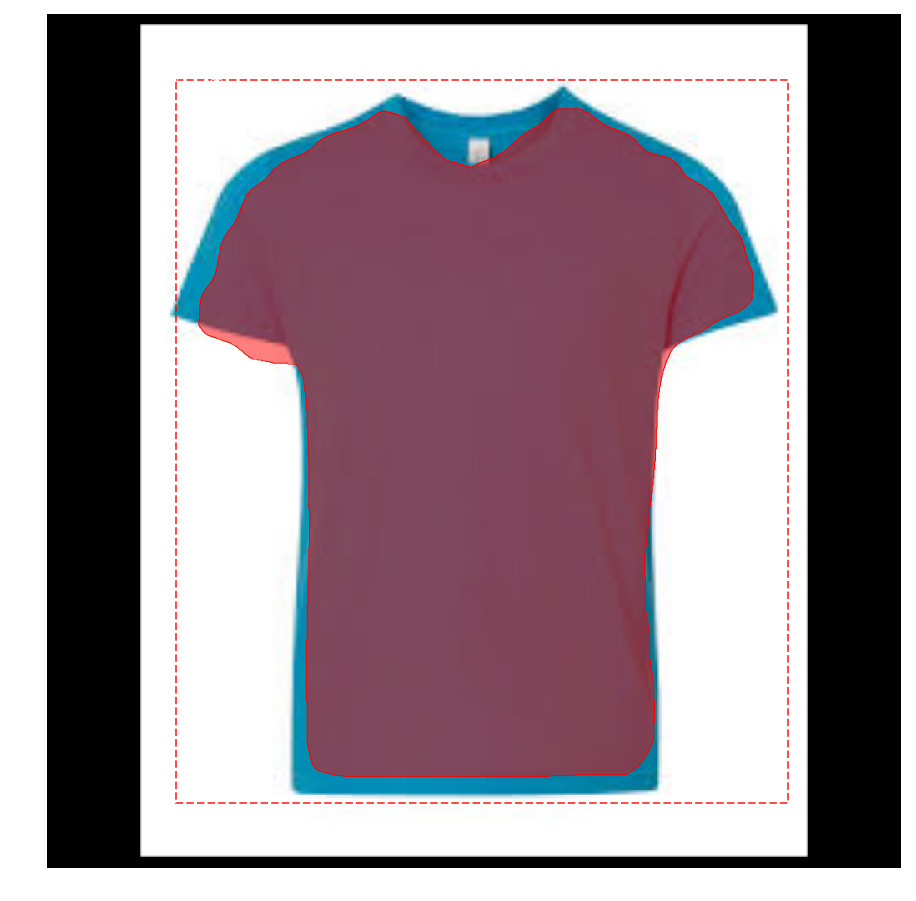

In [27]:

image_id = 21
#print(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,dataset.image_reference(image_id)))
#print(gt_mask)
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],dataset.class_names, r['scores'],ax=ax)


#log("gt_class_id", gt_class_id)
#log("gt_bbox", gt_bbox)
#log("gt_mask", gt_mask)

In [28]:
def trial_display_images(images, titles=None, cols=4, cmap=None, norm=None,loc="ooo.jpg",
                   interpolation=None):
    """Display the given set of images, optionally with titles.
    images: list or array of image tensors in HWC format.
    titles: optional. A list of titles to display with each image.
    cols: number of images per row
    cmap: Optional. Color map to use. For example, "Blues".
    norm: Optional. A Normalize instance to map values to colors.
    interpolation: Optional. Image interpolation to use for display.
    """
    titles = titles if titles is not None else [""] * len(images)
    rows = len(images) // cols + 1
    plt.figure(figsize=(14, 14 * rows // cols))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(image.astype(np.uint8), cmap=cmap,
                   norm=norm, interpolation=interpolation)
        i += 1
    plt.savefig(loc,bbox_inches='tight')
    #extent = plt.get_window_extent().transformed(plt.dpi_scale_trans.inverted())
    #plt.savefig('ax2_figure.png', bbox_inches=extent)
    #plt.savefig('ax2_figure_expanded.png', bbox_inches=extent.expanded(1.1, 1.2))
    plt.show()
    plt.close()


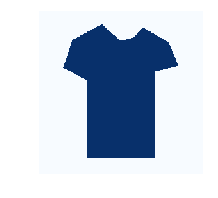

In [29]:
trial_display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")
    
    